<img src="https://hilpisch.com/tpq_logo_bic.png" width="20%" align="right">


# Fundamental Theorems of Asset Pricing
## Finite-State One-Period Markets

&copy; Dr. Yves J. Hilpisch<br>
AI-Powered by GPT 5.x<br>
The Python Quants GmbH | https://tpq.io<br>
https://hilpisch.com | https://linktr.ee/dyjh


## Notebook Goals

This notebook turns the one-period, finite-state models in the FTAP note into executable Python workflows.
We will

- compute risk-neutral probabilities and option prices in the two-state complete market,
- construct the replicating portfolio for a European put and check its payoffs state by state,
- describe the entire set of risk-neutral measures in the three-state incomplete market,
- visualize the resulting interval of no-arbitrage prices for a put option, and
- **(New)** Systematically plot the payoff geometry: the market plane, the non-attainable claim, and the hedging bounds.

All code is deliberately simple and heavily commented so that the link to the formulas in the note remains transparent.


### Getting Help While Studying FTAP

If you want to revisit the theory while experimenting with this notebook, the following references are useful:

- the main FTAP note for precise statements and proofs,
- the examples in the two-state and three-state sections of the note for parameter choices, and
- the PyAIAM notebooks (especially Chapters 1 and 4) for additional Python patterns in quantitative finance.


In [1]:
import numpy as np  # numerical arrays and linear algebra
import pandas as pd  # tabular summaries
import matplotlib.pyplot as plt  # plotting library
from matplotlib import cm  # color maps for 3d plots
from mpl_toolkits.mplot3d import Axes3D  # 3d plotting support
from pathlib import Path  # filesystem paths for saving figures

plt.style.use("seaborn-v0_8")  # basic plot style
plt.rcParams.update({
    "font.family": "serif",  # serif font to match the note
    "figure.dpi": 200,  # reasonably high resolution for export
    "font.size": 9,      # smaller base font
    "axes.labelsize": 8, # smaller axis labels
    "axes.titlesize": 10,# smaller titles
    "legend.fontsize": 8 # compact legend
})

FIG_SAVE = True  # set to True to export figures as PDF
FIG_DIR = Path("../figures")  # target directory for exported figures

def maybe_save(fig, name: str) -> None:
    """Save a Matplotlib figure under ftap/figures when FIG_SAVE is True."""
    if not FIG_SAVE:
        return  # no-op when exports are disabled
    FIG_DIR.mkdir(parents=True, exist_ok=True)  # ensure directory exists
    path = FIG_DIR / f"{name}.pdf"  # PDF file name
    fig.savefig(path, bbox_inches="tight")  # export figure


## 1. Two-State Complete Market

We first reproduce the smallest complete market from the note: one bond and one stock with two future states.
The parameters follow Example 5.1 (two-state put pricing):

- interest rate: $r=5\%$,
- initial stock price: $S_0=100$,
- stock payoffs: $S_u=130$, $S_d=80$.

We compute the unique risk-neutral probabilities, check the no-arbitrage inequalities, and price a European put by
both risk-neutral expectation and replication.


In [2]:
r = 0.05  # one-period interest rate
S0 = 100.0  # initial stock price
Su, Sd = 130.0, 80.0  # up and down stock prices

R = 1.0 + r  # gross risk-free return

# risk-neutral probabilities from the standard one-period formulas
qu = (R * S0 - Sd) / (Su - Sd)  # probability of up state under Q
qd = 1.0 - qu  # probability of down state under Q

qu, qd


(0.5, 0.5)

In [3]:
# verify no-arbitrage inequalities in the physical-free formulation
lhs = Sd / R  # lower bound for S0
rhs = Su / R  # upper bound for S0

print(f"No-arbitrage interval for S0: ({lhs:.2f}, {rhs:.2f})")  # interval from bounds
print(f"Given S0={S0:.2f}, inequalities hold: {lhs < S0 < rhs}")  # NA check


No-arbitrage interval for S0: (76.19, 123.81)
Given S0=100.00, inequalities hold: True


In [4]:
K = 100.0  # strike of the European put

# state-contingent payoffs of the put option
Xu = max(K - Su, 0.0)  # payoff in up state
Xd = max(K - Sd, 0.0)  # payoff in down state

# risk-neutral price via discounted expectation
put_price_q = (qu * Xu + qd * Xd) / R  # one-period pricing formula
put_price_q


9.523809523809524

In [5]:
# solve for the replicating portfolio (Delta shares of stock, b units of the bond)
Su_vec = np.array([Su, Sd], dtype=float)  # stock payoffs in both states
bond_vec = np.array([R, R], dtype=float)  # bond payoffs in both states
X_vec = np.array([Xu, Xd], dtype=float)  # put payoffs in both states

A = np.column_stack([Su_vec, bond_vec])  # payoff matrix for stock and bond
Delta, b = np.linalg.solve(A, X_vec)  # unique solution in the complete market

V0_rep = Delta * S0 + b * 1.0  # initial cost of the replicating portfolio

Delta, b, V0_rep


(np.float64(-0.4000000000000001),
 np.float64(49.523809523809526),
 np.float64(9.523809523809518))

In [6]:
# compare risk-neutral price and replication cost
print(f"Put price via Q-expectation     : {put_price_q:.4f}")  # expectation-based price
print(f"Put price via replication (V0) : {V0_rep:.4f}")  # portfolio-based price


Put price via Q-expectation     : 9.5238
Put price via replication (V0) : 9.5238


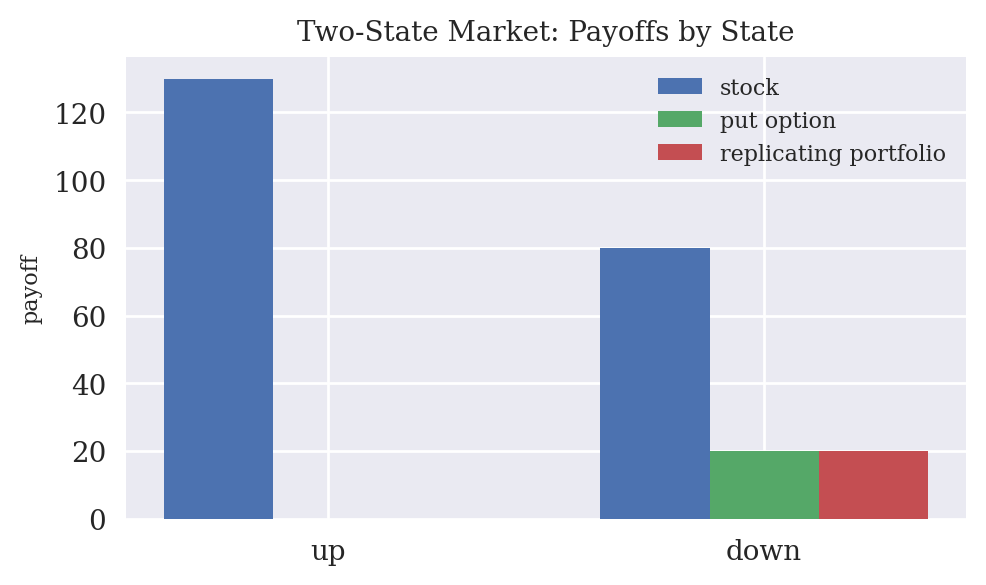

In [7]:
# visualize stock and put payoffs across the two states
states = ["up", "down"]  # labels for the two states
stock_payoffs = [Su, Sd]  # stock payoffs per state
put_payoffs = [Xu, Xd]  # put payoffs per state
rep_payoffs = list(A @ np.array([Delta, b]))  # replicating portfolio payoffs

x = np.arange(len(states))  # x positions for bar chart
width = 0.25  # bar width

fig, ax = plt.subplots(figsize=(5, 3))  # Compact figure
ax.bar(x - width, stock_payoffs, width, label="stock")  # stock bars
ax.bar(x, put_payoffs, width, label="put option")  # option bars
ax.bar(x + width, rep_payoffs, width, label="replicating portfolio")  # replication bars

ax.set_xticks(x)  # place x tick marks
ax.set_xticklabels(states)  # state labels
ax.set_ylabel("payoff")  # y-axis label
ax.set_title("Two-State Market: Payoffs by State")  # plot title
ax.legend()  # show legend
plt.tight_layout()
maybe_save(fig, "ftap_two_state_payoffs")  # optional export
plt.show()  # render the plot


The bar chart confirms that the replicating portfolio matches the put payoff in both states.
In this smallest complete market the FTAP II statement is fully visible: a unique martingale measure $\mathbf{Q}$ and a
unique replicating portfolio lead to a unique arbitrage-free price.


## 2. Three-State Incomplete Market

We now move to the three-state market with one bond and one stock. As in the note we take

- bond: $B_0=1$, $B_1=1+r$ with the same $r=5\%$,
- stock payoffs: $S_1(\omega_1)=140$, $S_1(\omega_2)=90$, $S_1(\omega_3)=60$,
- initial stock price: $S_0=100$.

This market is incomplete because two traded assets cannot span all three payoff coordinates.
We explicitly compute the set $\mathbb{Q}$ of risk-neutral measures and the resulting interval of no-arbitrage put prices.


In [8]:
S1 = np.array([140.0, 90.0, 60.0])  # stock payoffs in three states
S0_3 = 100.0  # initial stock price in three-state example

# we parameterize the set of Q by choosing q3 in the feasible interval
q3_grid = np.linspace(0.0, 0.4375, 100)  # grid for the free parameter q3

q1_grid = 0.3 + 0.6 * q3_grid  # from the algebra in the note
q2_grid = 0.7 - 1.6 * q3_grid  # ensures q1 + q2 + q3 = 1

q_df = pd.DataFrame({  # tabular summary for inspection
    "q1": q1_grid,
    "q2": q2_grid,
    "q3": q3_grid,
})
q_df.head()  # show first rows of the risk-neutral set


,q1,q2,q3
0,0.300000,0.700000,0.000000
1,0.302652,0.692929,0.004419
2,0.305303,0.685859,0.008838
3,0.307955,0.678788,0.013258
4,0.310606,0.671717,0.017677


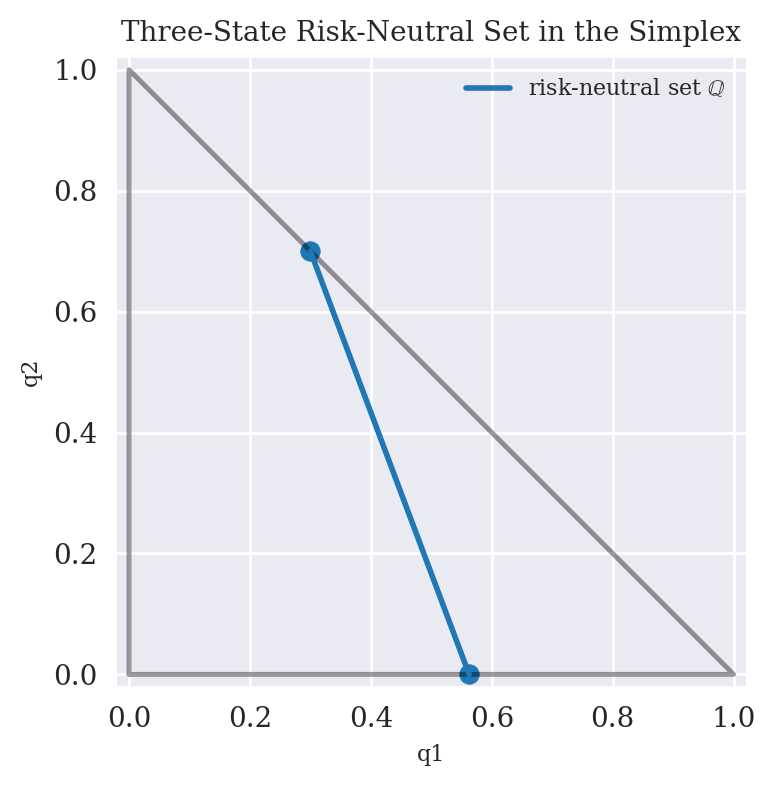

In [9]:
# visualize the admissible risk-neutral measures as a line segment in the simplex
fig, ax = plt.subplots(figsize=(4, 4))  # Compact square plot

ax.set_title("Three-State Risk-Neutral Set in the Simplex")  # title
ax.set_xlabel("q1")  # x-axis label
ax.set_ylabel("q2")  # y-axis label

# draw the boundary of the simplex q1 >= 0, q2 >= 0, q1 + q2 <= 1
simplex_x = [0.0, 1.0, 0.0, 0.0]  # triangle vertices in q1
simplex_y = [0.0, 0.0, 1.0, 0.0]  # triangle vertices in q2
ax.plot(simplex_x, simplex_y, "k-", alpha=0.4)  # simplex outline

# plot the line segment of risk-neutral measures
ax.plot(q1_grid, q2_grid, color="tab:blue", lw=2, label="risk-neutral set $\\mathbb{Q}$")

# mark the endpoints corresponding to the bounds in the note
ax.scatter(q1_grid[0], q2_grid[0], color="tab:blue")  # endpoint for q3 = 0
ax.scatter(q1_grid[-1], q2_grid[-1], color="tab:blue")  # endpoint for q3 = 0.4375

ax.legend(loc="upper right")  # legend position
ax.set_xlim(-0.02, 1.02)  # x-axis range
ax.set_ylim(-0.02, 1.02)  # y-axis range
ax.set_aspect("equal")  # equal scaling for simplex geometry
plt.tight_layout()
maybe_save(fig, "ftap_three_state_q_simplex")  # optional export
plt.show()  # render the plot


In [10]:
# put payoff in the three-state market
K_3 = 100.0  # strike of the put
X_three = np.maximum(K_3 - S1, 0.0)  # state-wise put payoff vector
X_three


array([ 0., 10., 40.])

In [11]:
# compute the arbitrage-free price interval by scanning over all Q in the line segment
prices = []  # container for discounted expectation prices
for q1, q2, q3 in zip(q1_grid, q2_grid, q3_grid):
    q_vec = np.array([q1, q2, q3])  # risk-neutral probabilities in a vector
    price_q = np.dot(q_vec, X_three) / R  # discounted expectation under this Q
    prices.append(price_q)  # store price for later analysis

prices = np.array(prices)  # convert to NumPy array for statistics
prices.min(), prices.max()  # no-arbitrage bounds from the risk-neutral set


(np.float64(6.666666666666666), np.float64(16.666666666666664))

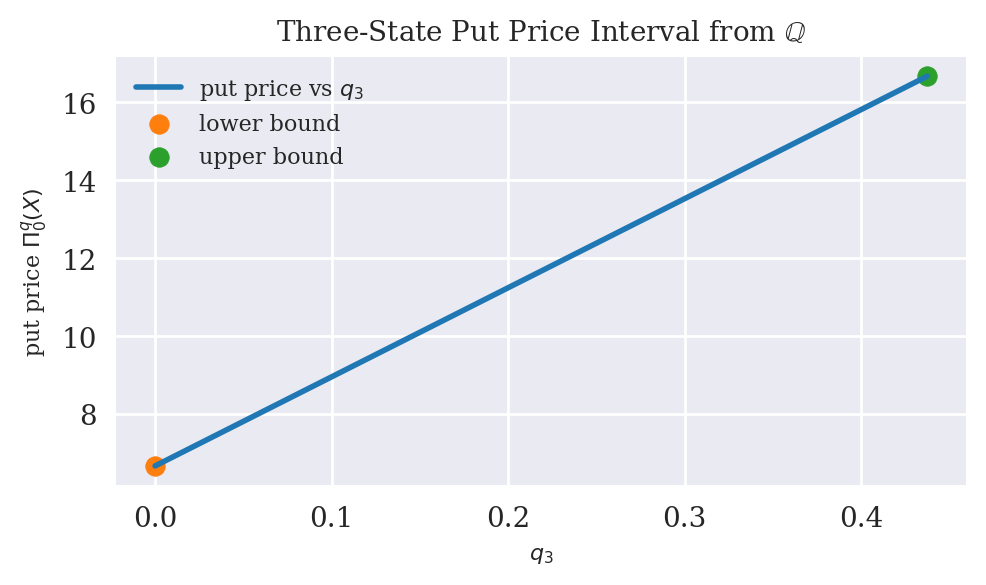

In [12]:
# visualize the no-arbitrage interval as a function of q3
fig, ax = plt.subplots(figsize=(5, 3))  # Compact figure
ax.plot(q3_grid, prices, color="tab:blue", lw=2, label="put price vs $q_3$")

ax.scatter(q3_grid[0], prices[0], color="tab:orange", label="lower bound")
ax.scatter(q3_grid[-1], prices[-1], color="tab:green", label="upper bound")

ax.set_xlabel("$q_3$")  # x-axis label
ax.set_ylabel("put price $\\Pi_0^q(X)$")  # y-axis label
ax.set_title("Three-State Put Price Interval from $\\mathbb{Q}$")  # title
ax.legend(loc="upper left")  # legend position
plt.tight_layout()
maybe_save(fig, "ftap_three_state_put_interval")  # optional export
plt.show()  # render the plot


The plot shows clearly how the no-arbitrage price range is generated by the admissible martingale measures.
The lower and upper endpoints correspond to the cheapest super-hedging and most expensive sub-hedging portfolios,
respectively, and match the bounds derived algebraically in the note.


## 3. Payoff Geometry in Three States

We now visualize the payoff geometry step-by-step. In an incomplete market:
1.  **The Attainable Plane ($\mathcal{M}$):** With 3 states but only 2 assets, we can only reach a plane of payoffs.
2.  **The Non-Attainable Claim ($X$):** Our Put option lies *outside* this plane. We cannot replicate it perfectly.
3.  **The Hedges:** The super-hedge ($Y^{\text{sup}}$) and sub-hedge ($Y^{\text{sub}}$) are points *on the plane* that sandwich $X$.

In [13]:
# --- 0. PRE-CALCULATION & SETUP ---
# We perform all linear algebra first to set up consistent axes for all 3 plots.

stock_payoff = np.array([140.0, 90.0, 60.0])  # Stock S1
bond_payoff = np.array([R, R, R])             # Bond B1
P = np.column_stack([stock_payoff, bond_payoff]) # Payoff Matrix

X_target = X_three  # [0, 10, 40]

# A. Orthogonal Projection
theta_proj, _, _, _ = np.linalg.lstsq(P, X_target, rcond=None)
X_proj = P @ theta_proj

# B. Super/Sub Hedges
pairs = [(0, 1), (0, 2), (1, 2)]
best_sup, best_sub = None, None

for i, j in pairs:
    A_pair = np.array([
        [stock_payoff[i], bond_payoff[i]],
        [stock_payoff[j], bond_payoff[j]]
    ])
    b_pair = np.array([X_target[i], X_target[j]])
    try:
        theta = np.linalg.solve(A_pair, b_pair)
    except np.linalg.LinAlgError:
        continue
    
    payoff = P @ theta
    cost = theta[0] * S0_3 + theta[1]

    if np.all(payoff >= X_target - 1e-9):
        if best_sup is None or cost < best_sup[0]:
            best_sup = (cost, theta, payoff)
            
    if np.all(payoff <= X_target + 1e-9):
        if best_sub is None or cost > best_sub[0]:
            best_sub = (cost, theta, payoff)

Y_sup, theta_sup = best_sup[2], best_sup[1]
Y_sub, theta_sub = best_sub[2], best_sub[1]

# C. Define Common Axis Limits to prevent distortion
# We center the view on the "cloud" of relevant points
all_points = np.vstack([X_target, Y_sup, Y_sub, X_proj])
center = np.mean(all_points, axis=0)
# Find maximum span to create a cubic bounding box
max_range = np.max(np.ptp(all_points, axis=0)) * 0.75 # Add padding

xlims = (center[0] - max_range, center[0] + max_range)
ylims = (center[1] - max_range, center[1] + max_range)
zlims = (center[2] - max_range, center[2] + max_range)

# D. Define Plane Grid (Tight around hedges)
# We determine the plane boundaries by looking at the specific hedge portfolios
# plus a small margin (10%) so it looks like a bounded patch.
thetas = np.vstack([theta_sup, theta_sub, theta_proj])
stock_coeffs = thetas[:, 0]
bond_coeffs = thetas[:, 1]

margin = 0.1 # 10% padding
da = np.ptp(stock_coeffs) * margin if np.ptp(stock_coeffs) > 0 else 0.1
db = np.ptp(bond_coeffs) * margin if np.ptp(bond_coeffs) > 0 else 5.0

a_vals = np.linspace(stock_coeffs.min() - da, stock_coeffs.max() + da, 10)
b_vals = np.linspace(bond_coeffs.min() - db, bond_coeffs.max() + db, 10)
A_mesh, B_mesh = np.meshgrid(a_vals, b_vals)

X1_plane = stock_payoff[0] * A_mesh + bond_payoff[0] * B_mesh
X2_plane = stock_payoff[1] * A_mesh + bond_payoff[1] * B_mesh
X3_plane = stock_payoff[2] * A_mesh + bond_payoff[2] * B_mesh

### 3.1 Step 1: The Attainable Payoff Plane $\mathcal{M}$

First, we plot the subspace of all possible portfolio payoffs. Any point on this plane is a linear combination of the Stock and Bond vectors.

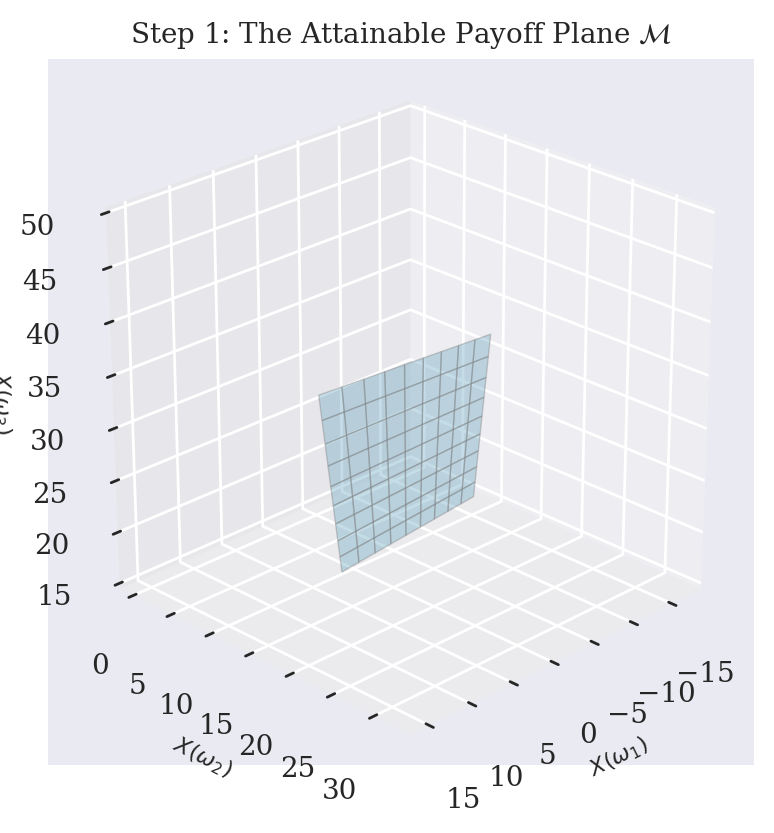

In [14]:
fig = plt.figure(figsize=(6, 4)) # Compact
ax = fig.add_subplot(111, projection="3d")

ax.plot_surface(
    X1_plane, X2_plane, X3_plane,
    alpha=0.4, color='skyblue', edgecolor='gray', linewidth=0.5
)

# Enforce consistent cubic view
ax.set_xlim(xlims); ax.set_ylim(ylims); ax.set_zlim(zlims)
ax.set_box_aspect((1, 1, 1)) # Important for preventing distortion

ax.set_xlabel('$X(\omega_1)$')
ax.set_ylabel('$X(\omega_2)$')
ax.set_zlabel('$X(\omega_3)$')
ax.set_title('Step 1: The Attainable Payoff Plane $\\mathcal{M}$')
ax.view_init(elev=25, azim=45)
plt.tight_layout()
plt.show()

### 3.2 Step 2: Adding the Claim $X$ and its Projection

We now add the target claim $X$ (the Put Option). Notice it floats *off* the plane.

**Note:** We also plot the **orthogonal projection** $X_{proj}$, which is the point on the plane geometrically closest to $X$. In Step 3, you will see that this projection usually does *not* lie on the line connecting the hedges. This is because hedging (inequalities/dominance) and projection (Euclidean distance) are mathematically distinct concepts in incomplete markets.

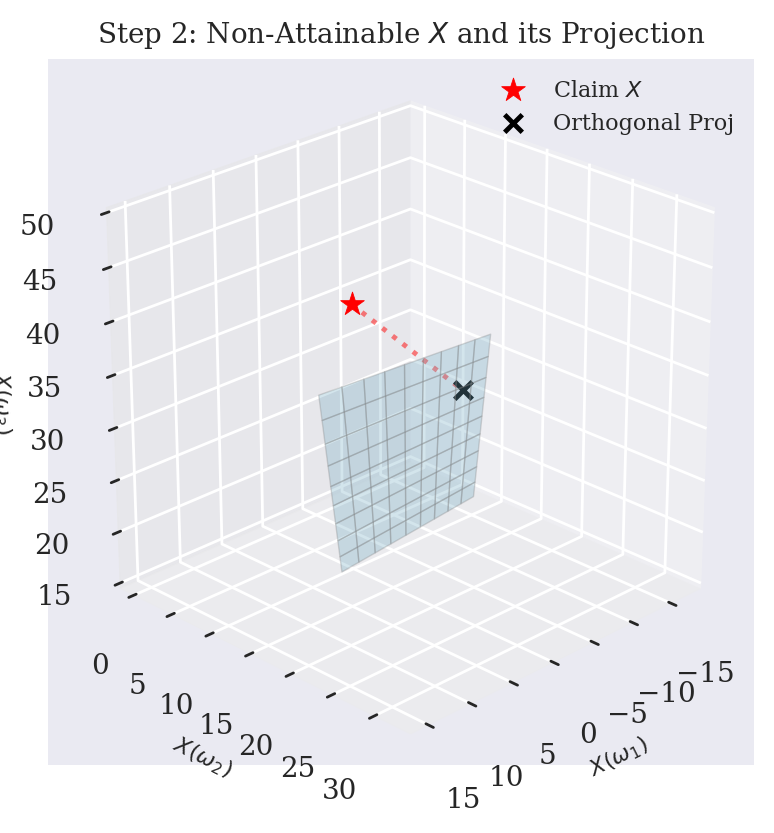

In [15]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection="3d")

# Plot Plane
ax.plot_surface(X1_plane, X2_plane, X3_plane, alpha=0.3, color='skyblue', edgecolor='gray', linewidth=0.5)

# Plot X (Red Star)
ax.scatter(*X_target, color='red', s=80, marker='*', label='Claim $X$')
# Plot Projection (Black X)
ax.scatter(*X_proj, color='black', marker='x', s=40, label='Orthogonal Proj')
# Connector
ax.plot(
    [X_target[0], X_proj[0]], [X_target[1], X_proj[1]], [X_target[2], X_proj[2]],
    color='red', linestyle=':', alpha=0.5
)

# Consistent View
ax.set_xlim(xlims); ax.set_ylim(ylims); ax.set_zlim(zlims)
ax.set_box_aspect((1, 1, 1))
ax.set_xlabel('$X(\omega_1)$'); ax.set_ylabel('$X(\omega_2)$'); ax.set_zlabel('$X(\omega_3)$')
ax.set_title('Step 2: Non-Attainable $X$ and its Projection')
ax.view_init(elev=25, azim=45)
ax.legend()
plt.tight_layout()
plt.show()

### 3.3 Step 3: Super- and Sub-Hedging Bounds

Finally, we find the **financial** bounds.
- **Super-hedge ($Y^{\text{sup}}$):** The cheapest point on the plane such that $Y^{\text{sup}} \ge X$ in all states.
- **Sub-hedge ($Y^{\text{sub}}$):** The most expensive point on the plane such that $Y^{\text{sub}} \le X$ in all states.

The segment connecting these two points (dashed line) represents the interval of no-arbitrage prices projected onto the payoff space.

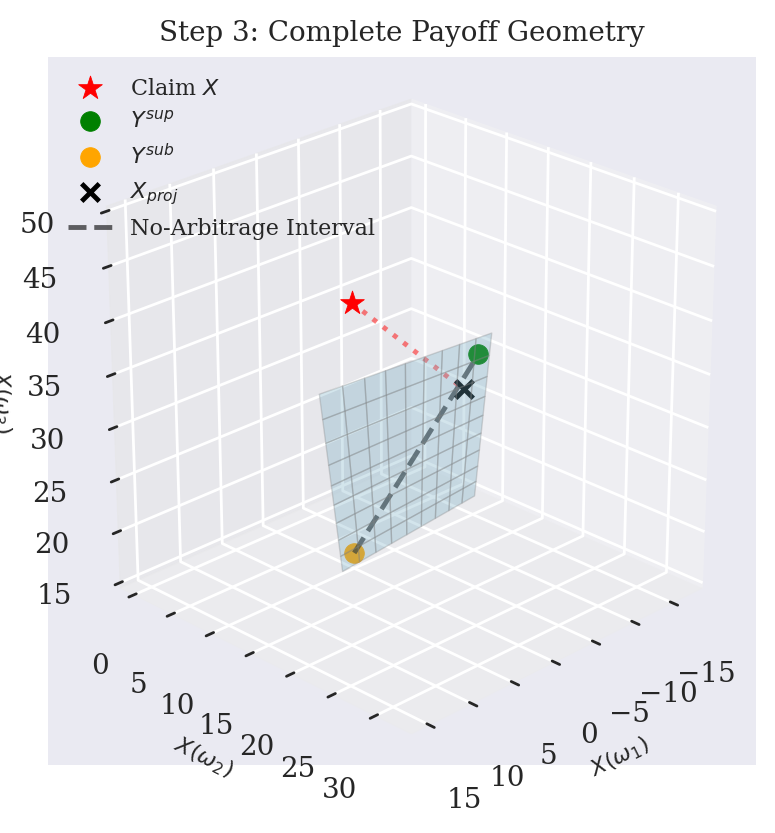

In [16]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection="3d")

ax.plot_surface(X1_plane, X2_plane, X3_plane, alpha=0.3, color='skyblue', edgecolor='gray', linewidth=0.5)

# Points
ax.scatter(*X_target, color='red', s=80, marker='*', label='Claim $X$')
ax.scatter(*Y_sup, color='green', s=50, label='$Y^{sup}$')
ax.scatter(*Y_sub, color='orange', s=50, label='$Y^{sub}$')
ax.scatter(*X_proj, color='black', marker='x', s=40, label='$X_{proj}$')

# Lines
ax.plot([Y_sub[0], Y_sup[0]], [Y_sub[1], Y_sup[1]], [Y_sub[2], Y_sup[2]], 'k--', alpha=0.6, label='No-Arbitrage Interval')
ax.plot([X_target[0], X_proj[0]], [X_target[1], X_proj[1]], [X_target[2], X_proj[2]], 'r:', alpha=0.5)

# Consistent View
ax.set_xlim(xlims); ax.set_ylim(ylims); ax.set_zlim(zlims)
ax.set_box_aspect((1, 1, 1))

ax.set_xlabel('$X(\omega_1)$')
ax.set_ylabel('$X(\omega_2)$')
ax.set_zlabel('$X(\omega_3)$')
ax.set_title('Step 3: Complete Payoff Geometry')
ax.view_init(elev=25, azim=45)
ax.legend(loc='upper left', bbox_to_anchor=(0,1))

plt.tight_layout()
maybe_save(fig, "ftap_three_state_geometry_final")
plt.show()

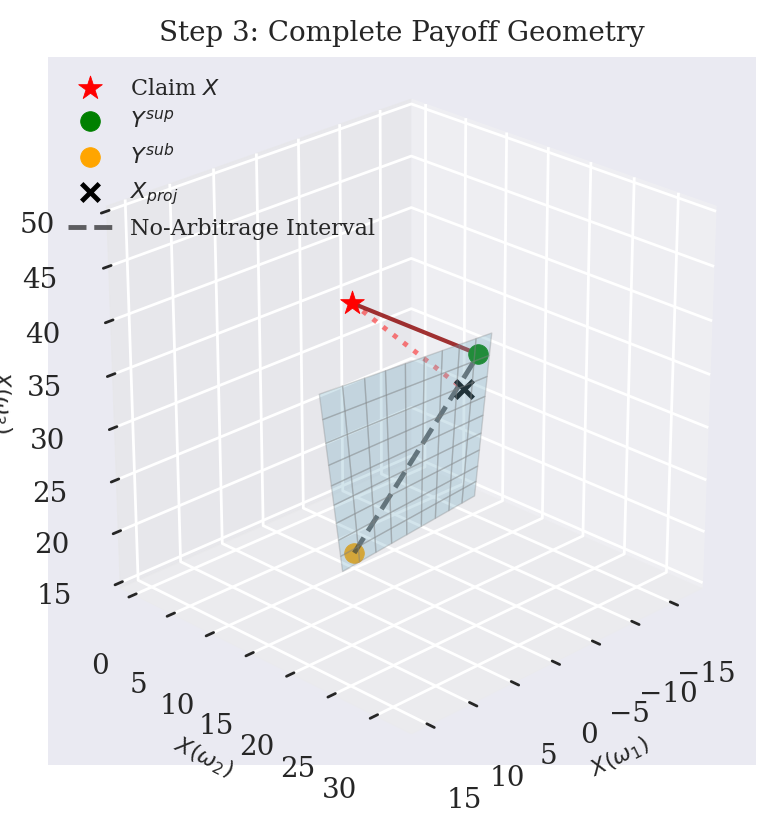

In [17]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection="3d")

ax.plot_surface(X1_plane, X2_plane, X3_plane, alpha=0.3, color='skyblue', edgecolor='gray', linewidth=0.5)

# Points
ax.scatter(*X_target, color='red', s=80, marker='*', label='Claim $X$')
ax.scatter(*Y_sup, color='green', s=50, label='$Y^{sup}$')
ax.scatter(*Y_sub, color='orange', s=50, label='$Y^{sub}$')
ax.scatter(*X_proj, color='black', marker='x', s=40, label='$X_{proj}$')

# Lines
ax.plot([Y_sub[0], Y_sup[0]], [Y_sub[1], Y_sup[1]], [Y_sub[2], Y_sup[2]], 'k--', alpha=0.6, label='No-Arbitrage Interval')
ax.plot([X_target[0], X_proj[0]], [X_target[1], X_proj[1]], [X_target[2], X_proj[2]], 'r:', alpha=0.5)

# --- NEW: Dominance Line (Visualizing the binding constraints) ---
# This line connects Claim X directly to Super-Hedge Y_sup
ax.plot([X_target[0], Y_sup[0]], [X_target[1], Y_sup[1]], [X_target[2], Y_sup[2]], 
        color='darkred', linestyle='-', linewidth=1.5, alpha=0.8)

# Consistent View
ax.set_xlim(xlims); ax.set_ylim(ylims); ax.set_zlim(zlims)
ax.set_box_aspect((1, 1, 1))

ax.set_xlabel('$X(\omega_1)$')
ax.set_ylabel('$X(\omega_2)$')
ax.set_zlabel('$X(\omega_3)$')
ax.set_title('Step 3: Complete Payoff Geometry')
ax.view_init(elev=25, azim=45)
ax.legend(loc='upper left', bbox_to_anchor=(0,1))

plt.tight_layout()
maybe_save(fig, "ftap_three_state_geometry_final")
plt.show()

### **Remark: Geometry vs. Finance**

You might notice in the plot above that the **orthogonal projection** ($X_{\text{proj}}$) does not lie on the dashed line connecting the hedges, nor does it align with the solid line connecting the claim to the super-hedge. This illustrates the distinction between geometry and financial optimization:

* **Geometric Projection ($X_{\text{proj}}$):** Minimizes the **Euclidean distance** (squared error) between the claim $X$ and the plane. It cares about "closeness" in a spatial sense, treating all directions equally. It is like minizing a least-squares hedging error.
* **Hedging Bounds ($Y^{\text{sup}}, Y^{\text{sub}}$):** Are determined by **no-arbitrage inequalities**. $Y^{\text{sup}}$ must dominate $X$ in *every single state*.
* **Binding Constraints (Solid Red Line):** The solid line connecting $X$ to $Y^{\text{sup}}$ visualizes the cost-minimization logic. The optimal super-hedge "touches" the claim payoff in as many states as possible (here, $\omega_1$ and $\omega_3$) and strictly dominates it only in the remaining state ($\omega_2$). This creates a path of **strict financial dominance** that is distinct from the shortest geometric path.

In incomplete markets, the "financially closest" portfolios (the hedges) and the "geometrically closest" portfolio (the projection) rarely coincide. The distance between them reflects the **unhedgeable risk** that cannot be eliminated by trading the bond and stock.

### Conclusion

The final 3D plot synthesizes the core message of the FTAP in incomplete markets:
1.  **Incompleteness:** The claim $X$ (red star) is not on the plane $\mathcal{M}$, so it cannot be replicated.
2.  **No-Arbitrage Interval:** The price of $X$ is bounded by the cost of the super-hedge (green) and sub-hedge (orange), which are the "closest" points on the plane in terms of dominance, distinct from the geometric projection.

<img src="https://hilpisch.com/tpq_logo_bic.png" width="20%" align="right">
